In [1]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full.bin"

In [2]:
#!pip install fasttext
#!pip install transformers
#import nltk
#nltk.download('punkt')

In [3]:
from ast import FloorDiv
import pandas as pd
import numpy as np
import scipy
import nltk
import re
import os
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from torch.optim import AdamW
from fasttext import load_model
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix, classification_report

## No clean

In [4]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2.csv')

In [5]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [6]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [7]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3501
3501
3501


In [8]:
print(max(map(lambda x: len(x), sentences)))

84


In [9]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [10]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        seq_lengths = np.sum(np.array(x_train) !=0, axis=1)

        x_emb_pack = torch.nn.utils.rnn.pack_padded_sequence(x_emb,seq_lengths, batch_first=True, enforce_sorted=False)

        output , (h_n, _) = self.lstm(x_emb_pack.float())
        
        out = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=85)  

        out = out[0] 

        #print(out.shape)
        #output, (h_n, _) = self.lstm(x_emb.float())

        out = self.dense(out)

        out = torch.nn.functional.log_softmax(out)

        return out

In [11]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [12]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [13]:
print(model)

Model(
  (gen_embedding): Embedding(6620, 300)
  (lstm): LSTM(300, 150, batch_first=True, bidirectional=True)
  (dense): Linear(in_features=300, out_features=3, bias=True)
)


In [14]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.80it/s]



epoch 0
	train_loss:1.079 valid_loss:1.059
	train_acc:47.65% valid_acc:53.81%
	train_f1:0.520 valid_f1:0.570
	train_confusion_matrix:
[[ 266  755  261]
 [ 542 2388  560]
 [ 436  898  488]]
	valid_confusion_matrix:
[[ 68 204  60]
 [ 99 736 130]
 [ 76 243 142]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.93it/s]



epoch 1
	train_loss:1.042 valid_loss:1.026
	train_acc:55.30% valid_acc:55.01%
	train_f1:0.550 valid_f1:0.552
	train_confusion_matrix:
[[ 161  771  362]
 [ 190 2694  580]
 [ 162  889  800]]
	valid_confusion_matrix:
[[ 32 183 117]
 [ 40 722 203]
 [ 30 218 213]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.45it/s]



epoch 2
	train_loss:1.006 valid_loss:0.994
	train_acc:58.32% valid_acc:56.66%
	train_f1:0.567 valid_f1:0.559
	train_confusion_matrix:
[[ 148  754  374]
 [ 141 2769  588]
 [  81  805  921]]
	valid_confusion_matrix:
[[ 29 186 117]
 [ 40 739 186]
 [ 25 208 228]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.44it/s]



epoch 3
	train_loss:0.975 valid_loss:0.959
	train_acc:59.27% valid_acc:58.13%
	train_f1:0.575 valid_f1:0.571
	train_confusion_matrix:
[[ 156  726  408]
 [ 113 2809  595]
 [  71  795  975]]
	valid_confusion_matrix:
[[ 32 184 116]
 [ 37 747 181]
 [ 27 191 243]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



epoch 4
	train_loss:0.942 valid_loss:0.920
	train_acc:60.85% valid_acc:60.98%
	train_f1:0.589 valid_f1:0.596
	train_confusion_matrix:
[[ 169  717  417]
 [  99 2878  516]
 [  66  779  984]]
	valid_confusion_matrix:
[[ 37 182 113]
 [ 34 789 142]
 [ 24 191 246]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.61it/s]



epoch 5
	train_loss:0.901 valid_loss:0.876
	train_acc:62.39% valid_acc:63.03%
	train_f1:0.605 valid_f1:0.627
	train_confusion_matrix:
[[ 195  689  401]
 [ 113 2895  468]
 [  76  735 1028]]
	valid_confusion_matrix:
[[ 52 161 119]
 [ 33 808 124]
 [ 29 184 248]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



epoch 6
	train_loss:0.854 valid_loss:0.843
	train_acc:64.58% valid_acc:65.19%
	train_f1:0.634 valid_f1:0.657
	train_confusion_matrix:
[[ 241  667  387]
 [ 118 3026  386]
 [ 105  680 1004]]
	valid_confusion_matrix:
[[ 71 154 107]
 [ 37 835  93]
 [ 36 185 240]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]



epoch 7
	train_loss:0.816 valid_loss:0.818
	train_acc:65.86% valid_acc:66.44%
	train_f1:0.657 valid_f1:0.671
	train_confusion_matrix:
[[ 317  583  406]
 [ 142 3009  349]
 [ 122  660 1038]]
	valid_confusion_matrix:
[[ 77 144 111]
 [ 41 838  86]
 [ 47 161 253]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.08it/s]



epoch 8
	train_loss:0.777 valid_loss:0.794
	train_acc:67.87% valid_acc:66.38%
	train_f1:0.675 valid_f1:0.674
	train_confusion_matrix:
[[ 334  570  367]
 [ 138 3054  326]
 [ 145  575 1092]]
	valid_confusion_matrix:
[[ 83 136 113]
 [ 46 826  93]
 [ 51 152 258]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.86it/s]



epoch 9
	train_loss:0.752 valid_loss:0.777
	train_acc:69.09% valid_acc:66.33%
	train_f1:0.686 valid_f1:0.671
	train_confusion_matrix:
[[ 354  542  376]
 [ 153 3059  301]
 [ 161  512 1158]]
	valid_confusion_matrix:
[[ 78 140 114]
 [ 44 828  93]
 [ 57 144 260]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.29it/s]



epoch 10
	train_loss:0.719 valid_loss:0.768
	train_acc:70.46% valid_acc:66.44%
	train_f1:0.697 valid_f1:0.676
	train_confusion_matrix:
[[ 394  530  382]
 [ 149 3051  284]
 [ 157  453 1219]]
	valid_confusion_matrix:
[[ 80 135 117]
 [ 42 835  88]
 [ 60 148 253]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.91it/s]



epoch 11
	train_loss:0.698 valid_loss:0.758
	train_acc:71.38% valid_acc:67.35%
	train_f1:0.712 valid_f1:0.690
	train_confusion_matrix:
[[ 432  490  366]
 [ 163 3059  278]
 [ 179  412 1218]]
	valid_confusion_matrix:
[[ 96 118 118]
 [ 57 827  81]
 [ 60 140 261]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.68it/s]



epoch 12
	train_loss:0.677 valid_loss:0.749
	train_acc:72.54% valid_acc:67.46%
	train_f1:0.727 valid_f1:0.692
	train_confusion_matrix:
[[ 483  470  348]
 [ 158 3098  251]
 [ 192  395 1210]]
	valid_confusion_matrix:
[[ 97 121 114]
 [ 56 832  77]
 [ 66 138 257]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.01it/s]



epoch 13
	train_loss:0.654 valid_loss:0.749
	train_acc:73.37% valid_acc:68.03%
	train_f1:0.738 valid_f1:0.701
	train_confusion_matrix:
[[ 530  427  336]
 [ 178 3049  251]
 [ 186  379 1261]]
	valid_confusion_matrix:
[[107 116 109]
 [ 57 832  76]
 [ 68 136 257]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.99it/s]



epoch 14
	train_loss:0.644 valid_loss:0.730
	train_acc:73.63% valid_acc:68.37%
	train_f1:0.748 valid_f1:0.702
	train_confusion_matrix:
[[ 589  386  313]
 [ 202 3035  248]
 [ 233  351 1216]]
	valid_confusion_matrix:
[[106 115 111]
 [ 62 826  77]
 [ 70 121 270]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.49it/s]



epoch 15
	train_loss:0.621 valid_loss:0.735
	train_acc:74.36% valid_acc:69.11%
	train_f1:0.748 valid_f1:0.712
	train_confusion_matrix:
[[ 550  425  321]
 [ 166 3105  233]
 [ 215  341 1277]]
	valid_confusion_matrix:
[[113 107 112]
 [ 53 825  87]
 [ 70 114 277]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.95it/s]



epoch 16
	train_loss:0.616 valid_loss:0.724
	train_acc:74.98% valid_acc:69.00%
	train_f1:0.759 valid_f1:0.710
	train_confusion_matrix:
[[ 610  369  290]
 [ 194 3056  262]
 [ 197  343 1293]]
	valid_confusion_matrix:
[[111 112 109]
 [ 55 833  77]
 [ 72 120 269]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.00it/s]



epoch 17
	train_loss:0.596 valid_loss:0.728
	train_acc:75.63% valid_acc:69.74%
	train_f1:0.767 valid_f1:0.720
	train_confusion_matrix:
[[ 651  361  297]
 [ 173 3056  241]
 [ 210  329 1293]]
	valid_confusion_matrix:
[[122 110 100]
 [ 53 837  75]
 [ 73 121 267]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.13it/s]



epoch 18
	train_loss:0.580 valid_loss:0.722
	train_acc:76.39% valid_acc:69.34%
	train_f1:0.775 valid_f1:0.714
	train_confusion_matrix:
[[ 663  353  290]
 [ 181 3103  220]
 [ 222  298 1295]]
	valid_confusion_matrix:
[[117 104 111]
 [ 56 817  92]
 [ 70 106 285]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.96it/s]


epoch 19
	train_loss:0.570 valid_loss:0.715
	train_acc:76.85% valid_acc:69.74%
	train_f1:0.777 valid_f1:0.722
	train_confusion_matrix:
[[ 648  336  315]
 [ 171 3065  227]
 [ 186  285 1333]]
	valid_confusion_matrix:
[[128  97 107]
 [ 63 813  89]
 [ 73 103 285]]


(0.3, 1.0)

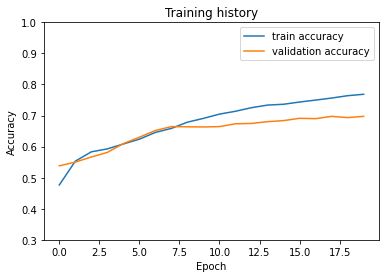

In [15]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [16]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full.bin


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/1978988207.py:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.07it/s]

              precision    recall  f1-score   support

     Neutral       0.48      0.39      0.43       332
    Positive       0.80      0.84      0.82       965
    Negative       0.59      0.62      0.61       461

    accuracy                           0.70      1758
   macro avg       0.63      0.62      0.62      1758
weighted avg       0.69      0.70      0.69      1758



In [17]:
MODEL_PATH

'model_task2_full.bin'

---

In [18]:
DATA_DIR = "./data/"
VALID_SIZE = .2
MODEL_PATH = "model_task2_full_clean.bin"

In [19]:
df = pd.read_csv('../Dataset/data/restaurants_laptop_train_with_pos_task2_cleaned.csv')

In [20]:
df.head()

,num,text,pos,aspect_tag,polarity
0,s_1,I,PRON,NAT,0
1,s_1,charge,VERB,NAT,0
2,s_1,it,PRON,NAT,0
3,s_1,at,ADP,NAT,0
4,s_1,night,NOUN,NAT,0


In [21]:
# replace all -1 to 2 since pytorch cannot handle negative
# so, 2 now means negative polarity
df.polarity = df.polarity.replace(-1,2)

encoder = preprocessing.LabelEncoder()
df.loc[:, "aspect_tag"] = encoder.fit_transform(df["aspect_tag"])

sentences = df.groupby("num")["text"].apply(list).values
aspect_tags = df.groupby("num")["aspect_tag"].apply(list).values
polarity_tags = df.groupby("num")["polarity"].apply(list).values

polarity_unique_values = df.polarity.unique()

print('num of aspect tags: {}'.format(len(encoder.classes_)))
print('num of polarity tags: {}'.format(len(polarity_unique_values)))

np.where(encoder.classes_ == "AT")[0].item()

num of aspect tags: 2
num of polarity tags: 4


0

In [22]:
print(len(sentences))
print(len(aspect_tags))
print(len(polarity_tags))

3501
3501
3501


In [23]:
print(max(map(lambda x: len(x), sentences)))

80


In [24]:
# generate word_index list
def build_vocab(df):
    word_idx = {}
    for idx, word in enumerate(sorted(set(df.text.values))):
        word_idx[word] = idx + 1
    return word_idx

def gen_np_embedding(fn, word_idx, dim=100, emb=False):
    if emb:
        model = load_model(fn + ".bin")
    embedding = np.zeros((len(word_idx) + 2, dim))

    with open(fn, encoding="utf8") as f:
        for l in f:
            # for each line, get the word and its vector
            rec = l.rstrip().split(' ')
            if len(rec) == 2:  # skip the first line.
                continue
                # if the word in word_idx, fill the embedding
            if rec[0] in word_idx:
                embedding[word_idx[rec[0]]] = np.array([float(r) for r in rec[1:]])
    for w in word_idx:
        if embedding[word_idx[w]].sum() == 0.:
            if emb:
                embedding[word_idx[w]] = model.get_word_vector(w)
    return embedding

def create_train_data_restaurant(sentences, word_idx, pol_tags, sent_len=85):
    train_X = np.zeros((len(sentences), sent_len), np.int16)
    mask = np.zeros_like(train_X)

    train_y = np.zeros((len(sentences), sent_len), np.int16)

    # iterate the sentence
    for sx, sent in enumerate(sentences):
        # write word index and tag in train_X
        try:
            for wx, word in enumerate(sent):
                train_X[sx, wx] = word_idx[word]
                if aspect_tags[sx][wx] == 0:
                    mask[sx, wx] = 1
                elif aspect_tags[sx][wx] == 1:
                    mask[sx, wx] = 0
                train_y[sx, wx] = pol_tags[sx][wx]
        except KeyError:
            continue

    return (train_X, mask), train_y



def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    elif isinstance(data, dict):
        for k, v in data.items():
            data[k] = v.to(device)
        return data
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


def loss_fn(pred, mask, label, num_tag):
    label.masked_fill_(~mask, -100)
    pred = pred.view(-1, num_tag)
    label = label.view(-1)
    loss = torch.nn.functional.cross_entropy(pred, label)
    return loss


def cal_acc(pred_tags, mask, true_tags):
    if isinstance(pred_tags, list):
        pred_tags = torch.cat(pred_tags, 0)
        mask = torch.cat(mask, 0)
        true_tags = torch.cat(true_tags, 0)
    pred_tags = pred_tags[mask]
    true_tags = true_tags[mask]
    acc = (pred_tags == true_tags).sum() / pred_tags.numel()
    f1 = f1_score(true_tags.cpu().numpy(), pred_tags.cpu().numpy(), labels=[0, 1], average='weighted')
    cm = confusion_matrix(true_tags.cpu().numpy(), pred_tags.cpu().numpy())

    return acc, f1, cm


In [25]:
'''
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        output, (h_n, _) = self.lstm(x_emb.float())
        out = self.dense(output)

        return out
'''

'\nclass Model(torch.nn.Module):\n    def __init__(self, gen_emb, num_classes=3):\n        super(Model, self).__init__()\n        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])\n        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)\n        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)\n        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)\n\n    def forward(self, x_train):\n        x_emb = self.gen_embedding(x_train)\n\n        output, (h_n, _) = self.lstm(x_emb.float())\n        out = self.dense(output)\n\n        return out\n'

In [26]:
class Model(torch.nn.Module):
    def __init__(self, gen_emb, num_classes=3):
        super(Model, self).__init__()
        self.gen_embedding = torch.nn.Embedding(gen_emb.shape[0], gen_emb.shape[1])
        self.gen_embedding.weight = torch.nn.Parameter(torch.from_numpy(gen_emb), requires_grad=False)
        self.lstm = nn.LSTM(gen_emb.shape[1], hidden_size=150, num_layers=1, bidirectional=True, batch_first=True)
        self.dense = torch.nn.Linear(gen_emb.shape[1], num_classes)

    def forward(self, x_train):
        x_emb = self.gen_embedding(x_train)

        seq_lengths = np.sum(np.array(x_train) !=0, axis=1)

        x_emb_pack = torch.nn.utils.rnn.pack_padded_sequence(x_emb,seq_lengths, batch_first=True, enforce_sorted=False)

        output , (h_n, _) = self.lstm(x_emb_pack.float())
        
        out = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True, total_length=85)  

        out = out[0] 

        out = self.dense(out)

        out = torch.nn.functional.log_softmax(out)


        return out

In [27]:
word_indx = build_vocab(df)

fn = DATA_DIR + 'glove.840B.300d.txt'
general_embedding = gen_np_embedding(fn, word_indx, dim=300, emb=False)


(X, mask), y = create_train_data_restaurant(sentences, word_indx, polarity_tags, sent_len=85)

X_train, X_valid, mask_train, mask_valid, y_train, y_valid = train_test_split(X, mask, y, test_size=VALID_SIZE)

In [28]:
device = get_default_device()

NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 128
VALID_BATCH_SIZE = 1024

NUM_POLARITY_TAGS = 3

dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(mask_train), torch.Tensor(y_train))
print(f"train samples:{len(dataset)}")
train_loader = DataLoader(dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True)

dataset_valid = TensorDataset(torch.Tensor(X_valid), torch.Tensor(mask_valid), torch.Tensor(y_valid))
print(f"valid samples:{len(dataset_valid)}")
test_loader = DataLoader(dataset_valid, batch_size=VALID_BATCH_SIZE)

model = to_device(Model(general_embedding,  num_classes=3), device)

torch.cuda.empty_cache()

parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = AdamW(parameters, lr=1e-4)


train samples:2800
valid samples:701


In [29]:
history = {
    "train_loss": list(),
    "polarity_train_acc": list(),
    "valid_loss": list(),
    "polarity_valid_acc": list(),
}

best_loss = np.inf

for epoch in range(NUM_EPOCHS):
    train_losses = []
    train_acc = []
    test_loss = []
    test_acc = []
    train_f1 = []
    test_f1 = []

    model.train()
    preds = []
    masks = []
    labels = []
    for data in tqdm(train_loader, total=len(train_loader)):
        for i in range(len(data)):
            data[i] = data[i].to(device)
        feature, mask, label = data
        feature, mask, label = feature.long(), mask.bool(), label.long()
        optimizer.zero_grad()
        pred_logits = model(feature)
        loss = loss_fn(pred_logits, mask, label, 3)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        pred_tags = pred_logits.max(-1)[1]
        preds.append(pred_tags)
        masks.append(mask)
        labels.append(label)

    avg_train_acc, avg_train_f1, train_cm = cal_acc(preds, masks, labels)
    avg_train_loss = sum(train_losses) / len(train_losses)

    preds = []
    masks = []
    labels = []
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)
            loss = loss_fn(pred_logits, mask, label, 3)

            test_loss.append(loss.item())

            pred_tags = pred_logits.max(-1)[1]

            preds.append(pred_tags)
            masks.append(mask)
            labels.append(label)

    avg_test_acc, avg_test_f1, test_cm = cal_acc(preds, masks, labels)
    avg_test_loss = sum(test_loss) / len(test_loss)

    print(f"\nepoch {epoch}")
    print("\ttrain_loss:{:.3f} valid_loss:{:.3f}".format(avg_train_loss, avg_test_loss))
    print("\ttrain_acc:{:.2%} valid_acc:{:.2%}".format(avg_train_acc, avg_test_acc))
    print("\ttrain_f1:{:.3f} valid_f1:{:.3f}".format(avg_train_f1, avg_test_f1))
    print(f"\ttrain_confusion_matrix:\n{train_cm}")
    print(f"\tvalid_confusion_matrix:\n{test_cm}")

    if avg_test_loss < best_loss:
        torch.save(model.state_dict(), MODEL_PATH)
        best_loss = avg_test_loss    
        
    history['train_loss'].append(avg_train_loss)
    history['polarity_train_acc'].append(avg_train_acc.cpu().numpy())
    history['valid_loss'].append(avg_test_loss)
    history['polarity_valid_acc'].append(avg_test_acc.cpu().numpy())


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.97it/s]



epoch 0
	train_loss:1.080 valid_loss:1.063
	train_acc:47.08% valid_acc:52.45%
	train_f1:0.480 valid_f1:0.518
	train_confusion_matrix:
[[ 162  618  504]
 [ 555 2060  875]
 [ 238  665  852]]
	valid_confusion_matrix:
[[ 30 162 132]
 [ 46 616 229]
 [ 27 211 244]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.18it/s]



epoch 1
	train_loss:1.042 valid_loss:1.031
	train_acc:55.13% valid_acc:55.04%
	train_f1:0.529 valid_f1:0.542
	train_confusion_matrix:
[[  84  705  494]
 [ 126 2575  791]
 [  72  760  963]]
	valid_confusion_matrix:
[[ 33 161 130]
 [ 28 649 214]
 [ 20 210 252]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.64it/s]



epoch 2
	train_loss:1.006 valid_loss:1.000
	train_acc:56.90% valid_acc:56.51%
	train_f1:0.540 valid_f1:0.551
	train_confusion_matrix:
[[  86  707  496]
 [ 104 2630  731]
 [  51  726 1000]]
	valid_confusion_matrix:
[[ 31 162 131]
 [ 24 671 196]
 [ 14 211 257]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.19it/s]



epoch 3
	train_loss:0.967 valid_loss:0.964
	train_acc:59.33% valid_acc:59.63%
	train_f1:0.565 valid_f1:0.578
	train_confusion_matrix:
[[ 102  712  453]
 [  81 2786  634]
 [  53  738 1008]]
	valid_confusion_matrix:
[[ 34 167 123]
 [ 18 717 156]
 [ 20 201 261]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.44it/s]



epoch 4
	train_loss:0.927 valid_loss:0.924
	train_acc:60.84% valid_acc:61.23%
	train_f1:0.585 valid_f1:0.596
	train_confusion_matrix:
[[ 130  706  436]
 [  94 2908  535]
 [  61  753  978]]
	valid_confusion_matrix:
[[ 44 168 112]
 [ 33 732 126]
 [ 22 197 263]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.58it/s]



epoch 5
	train_loss:0.884 valid_loss:0.889
	train_acc:63.15% valid_acc:62.76%
	train_f1:0.615 valid_f1:0.612
	train_confusion_matrix:
[[ 195  694  376]
 [  89 2962  424]
 [  84  744  974]]
	valid_confusion_matrix:
[[ 48 168 108]
 [ 32 759 100]
 [ 30 194 258]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.51it/s]



epoch 6
	train_loss:0.842 valid_loss:0.859
	train_acc:65.81% valid_acc:63.05%
	train_f1:0.652 valid_f1:0.623
	train_confusion_matrix:
[[ 276  599  391]
 [ 106 3008  371]
 [  90  680 1021]]
	valid_confusion_matrix:
[[ 58 159 107]
 [ 43 755  93]
 [ 40 185 257]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.68it/s]



epoch 7
	train_loss:0.808 valid_loss:0.836
	train_acc:66.76% valid_acc:63.88%
	train_f1:0.662 valid_f1:0.638
	train_confusion_matrix:
[[ 302  610  369]
 [ 111 3060  341]
 [  93  665 1035]]
	valid_confusion_matrix:
[[ 68 153 103]
 [ 42 761  88]
 [ 47 180 255]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.55it/s]



epoch 8
	train_loss:0.768 valid_loss:0.819
	train_acc:69.22% valid_acc:64.00%
	train_f1:0.680 valid_f1:0.639
	train_confusion_matrix:
[[ 315  589  351]
 [ 128 3093  296]
 [ 104  549 1129]]
	valid_confusion_matrix:
[[ 72 149 103]
 [ 50 747  94]
 [ 55 160 267]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.98it/s]



epoch 9
	train_loss:0.734 valid_loss:0.808
	train_acc:70.40% valid_acc:65.00%
	train_f1:0.695 valid_f1:0.657
	train_confusion_matrix:
[[ 345  541  381]
 [ 120 3097  290]
 [ 113  497 1176]]
	valid_confusion_matrix:
[[ 86 130 108]
 [ 53 738 100]
 [ 65 138 279]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  3.10it/s]



epoch 10
	train_loss:0.707 valid_loss:0.803
	train_acc:71.49% valid_acc:64.76%
	train_f1:0.712 valid_f1:0.661
	train_confusion_matrix:
[[ 422  522  342]
 [ 154 3091  279]
 [ 169  403 1173]]
	valid_confusion_matrix:
[[101 126  97]
 [ 71 726  94]
 [ 75 135 272]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.57it/s]



epoch 11
	train_loss:0.687 valid_loss:0.797
	train_acc:72.21% valid_acc:65.00%
	train_f1:0.718 valid_f1:0.664
	train_confusion_matrix:
[[ 437  491  355]
 [ 160 3069  246]
 [ 170  397 1220]]
	valid_confusion_matrix:
[[104 124  96]
 [ 69 722 100]
 [ 73 132 277]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  4.27it/s]



epoch 12
	train_loss:0.663 valid_loss:0.792
	train_acc:73.08% valid_acc:65.65%
	train_f1:0.734 valid_f1:0.676
	train_confusion_matrix:
[[ 472  447  319]
 [ 168 3095  260]
 [ 188  385 1229]]
	valid_confusion_matrix:
[[111 124  89]
 [ 65 738  88]
 [ 86 131 265]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  6.17it/s]



epoch 13
	train_loss:0.649 valid_loss:0.788
	train_acc:73.57% valid_acc:66.29%
	train_f1:0.736 valid_f1:0.684
	train_confusion_matrix:
[[ 502  451  324]
 [ 171 3069  251]
 [ 168  368 1253]]
	valid_confusion_matrix:
[[118 118  88]
 [ 64 738  89]
 [ 88 125 269]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  6.55it/s]



epoch 14
	train_loss:0.633 valid_loss:0.791
	train_acc:73.87% valid_acc:65.53%
	train_f1:0.746 valid_f1:0.675
	train_confusion_matrix:
[[ 554  412  309]
 [ 184 3075  237]
 [ 209  366 1226]]
	valid_confusion_matrix:
[[116 109  99]
 [ 76 713 102]
 [ 85 114 283]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  6.89it/s]



epoch 15
	train_loss:0.622 valid_loss:0.788
	train_acc:75.24% valid_acc:66.41%
	train_f1:0.761 valid_f1:0.688
	train_confusion_matrix:
[[ 583  363  331]
 [ 181 3093  241]
 [ 186  328 1277]]
	valid_confusion_matrix:
[[126 117  81]
 [ 67 734  90]
 [ 93 122 267]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  5.45it/s]



epoch 16
	train_loss:0.603 valid_loss:0.786
	train_acc:76.19% valid_acc:66.71%
	train_f1:0.771 valid_f1:0.692
	train_confusion_matrix:
[[ 589  345  306]
 [ 170 3094  240]
 [ 182  312 1292]]
	valid_confusion_matrix:
[[129 114  81]
 [ 67 734  90]
 [ 96 117 269]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  6.72it/s]



epoch 17
	train_loss:0.589 valid_loss:0.796
	train_acc:76.63% valid_acc:66.82%
	train_f1:0.776 valid_f1:0.695
	train_confusion_matrix:
[[ 632  353  293]
 [ 157 3107  221]
 [ 194  314 1284]]
	valid_confusion_matrix:
[[129 110  85]
 [ 65 736  90]
 [ 99 114 269]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  7.20it/s]



epoch 18
	train_loss:0.584 valid_loss:0.788
	train_acc:76.19% valid_acc:66.23%
	train_f1:0.773 valid_f1:0.692
	train_confusion_matrix:
[[ 634  341  321]
 [ 179 3099  236]
 [ 193  301 1293]]
	valid_confusion_matrix:
[[133 112  79]
 [ 70 733  88]
 [110 114 258]]


  0%|          | 0/21 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  6.41it/s]


epoch 19
	train_loss:0.565 valid_loss:0.787
	train_acc:77.68% valid_acc:66.65%
	train_f1:0.788 valid_f1:0.694
	train_confusion_matrix:
[[ 676  314  289]
 [ 175 3094  201]
 [ 203  276 1304]]
	valid_confusion_matrix:
[[136 106  82]
 [ 75 722  94]
 [102 107 273]]


(0.3, 1.0)

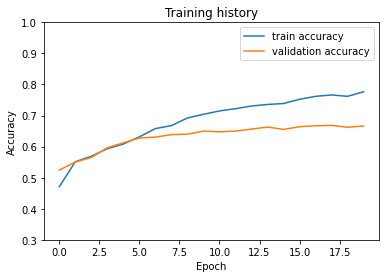

In [30]:
plt.plot(history['polarity_train_acc'], label='train accuracy')
plt.plot(history['polarity_valid_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.3, 1])

In [31]:
def get_classification_report(test_loader, model, model_path=None):
    if model_path is not None: # load the saved model
        print('Loading saved model from: {}'.format(model_path))
        model.load_state_dict(torch.load(model_path))
    model = to_device(model, device)   
    
    model.eval()
    final_pred_polarity_tags = []
    final_true_polarity_tags = []

    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader)):
            for i in range(len(data)):
                data[i] = data[i].to(device)
            feature, mask, label = data
            feature, mask, label = feature.long(), mask.bool(), label.long()
            pred_logits = model(feature)

            pred_tags = pred_logits.max(-1)[1]

            pred_tags = pred_tags[mask]
            label = label[mask]

            final_pred_polarity_tags.extend(pred_tags)
            final_true_polarity_tags.extend(label)

    final_pred_polarity_tags = torch.stack(final_pred_polarity_tags).cpu()
    final_true_polarity_tags = torch.stack(final_true_polarity_tags).cpu()
        
    print(classification_report(final_true_polarity_tags, final_pred_polarity_tags, 
                                target_names=["Neutral", "Positive", "Negative"]))
    
get_classification_report(test_loader, model, model_path=MODEL_PATH)

Loading saved model from: model_task2_full_clean.bin


  0%|          | 0/1 [00:00<?, ?it/s]/var/folders/3c/71b8pg6d7j5dht_5h_2n4n_c0000gn/T/ipykernel_12578/2772296862.py:24: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)
100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

              precision    recall  f1-score   support

     Neutral       0.44      0.40      0.42       324
    Positive       0.76      0.82      0.79       891
    Negative       0.61      0.56      0.58       482

    accuracy                           0.67      1697
   macro avg       0.60      0.59      0.60      1697
weighted avg       0.66      0.67      0.66      1697



In [32]:
MODEL_PATH

'model_task2_full_clean.bin'